# Create and load data to an Amazon Kinesis stream

Version: 30 Sep 2022

Authors: Charles Smith & Victoria Lim

## Resources
* Tech docs team drive: https://drive.google.com/drive/folders/1i5vlQks9Ij7AeRNAJFeMxDxJ1lLZ3-h8
* Boto3 docs
    * [`client`](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/core/session.html?highlight=session.client#boto3.session.Session.client): configs for creating a client, such as to pass in your AWS credentials
    * [`get_records`](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/kinesis.html#Kinesis.Client.get_records): to verify that your stream has records
* AWS docs:
    * [Get the record](https://docs.aws.amazon.com/streams/latest/dev/fundamental-stream.html#get-records): to get the `ShardIterator` to pass into Boto3's function `get_records`. I ran the following in the command line to get the `ShardIterator`:
    ```
    aws kinesis get-shard-iterator --shard-id shardId-000000000000 --shard-iterator-type TRIM_HORIZON --stream-name vt-test-3 --profile 422682147474_PowerUserAccess --region us-east-1
    ```
* [Druid doc for Kinesis ingestion](https://druid.apache.org/docs/latest/development/extensions-core/kinesis-ingestion.html)
    
## In this notebook

This notebook requires the `boto3` module, the Amazon Web Services SDK for Python.

Overview of what this notebook does:
1. `boto3.client` - Creates a Boto3 client using the given credentials and region (where the stream should be created).
2. `get_stream()` - Checks for the stream name specified in `stream` and creates the stream if not present. You can also create the stream in the AWS UI before running this notebook as is.
3. `load_records()` - Loads records one by one into the stream from the JSON file `wikipedia-2016-06-27-sampled.json`.
4. `kinesis.get_records()` - Gets the records in the stream to verify that they are loaded succesfully. Requires the `ShardIterator` string. See the example command listed in the **Resources** section above.


## Docker approach

Running through this Jupyter notebook is equivalent to running this Docker command:
```
docker run -v  ${HOME}/.aws/credentials:/root/.aws/credentials:ro \
  -e "AWS_PROFILE=422682147474_PowerUserAccess" \
  -e "AWS_DEFAULT_REGION=us-east-1" \
  -it sfsmithcha/pykenesis:0.1
```

The Docker approach creates a stream called `wiki_kinesis_tutorial` and loads data from the JSON file (see Google Drive link).

See more documentation for it at the Docker website:
https://hub.docker.com/r/sfsmithcha/pykenesis


## AWS credentials
Your credentials should be located in `~/.aws/credentials`.

The credentials you use to publish Imply docs may be **different** than the credentials you have through single sign-on (through Okta). Verify that you can create and view Kinesis streams in the UI.

### Create a stream in the UI

If you get errors running the Docker command or running `get_stream()` in this notebook, first verify that you can create a stream in the UI.

1. From your Imply Okta account, click the AWS single sign-on tile.
   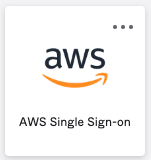
2. Click AWS account > Engineering.
   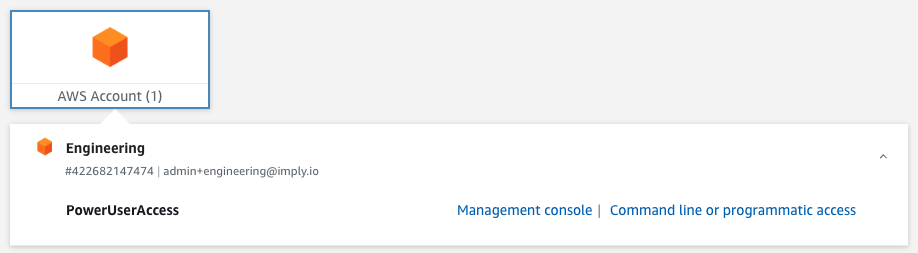
3. Select **Management console**.
4. Search for "kinesis".
5. Go through the flow of creating a data stream. Give your stream a unique name, and use the default settings provided in the UI.
6. Verify that you can view your streams:
   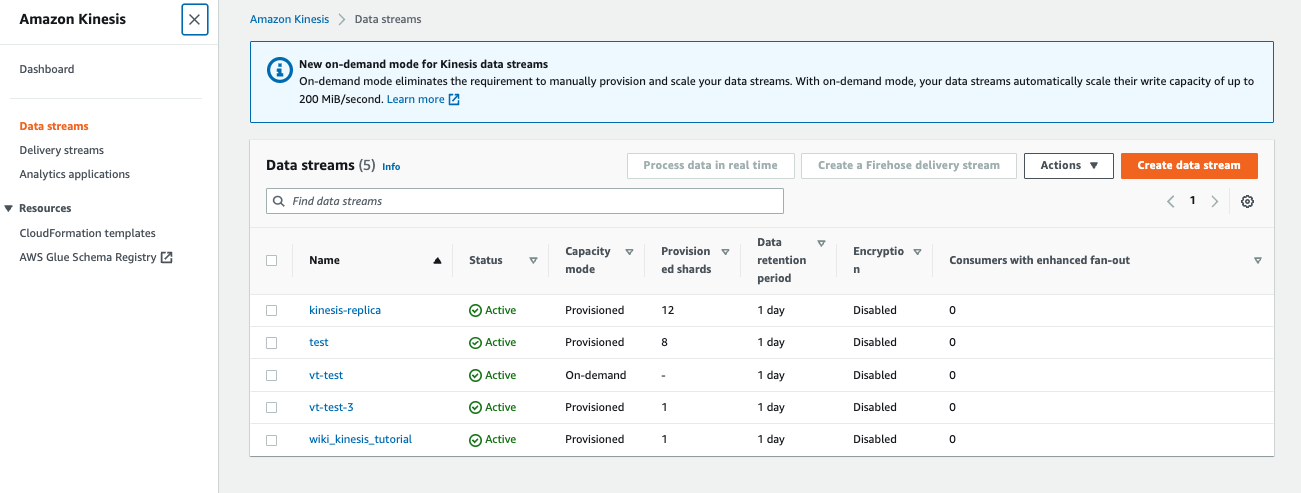
   
> Kinesis is costly! Delete your streams when you are finished working with them.

### Update credentials

If you CAN create a stream in the UI but can't run the Docker command or `get_stream()` without permission failure, update your credentials as follows.

> These steps are subject to change based on how Imply enables access to AWS and the AWS UI itself.

1. Follow the first two steps in **Create a stream in the UI**.
2. Select **Command line or programmatic access**.
3. Complete option 2 to add the profile to your `~/.aws/credentials` file.
The snippet you add to your file should look something like this:
```
[422682147474_PowerUserAccess]
aws_access_key_id=asdfasdf
aws_secret_access_key=123456
aws_session_token=123456
```

The key ID, access key, and token values are used in this notebook to create the Boto3 client in `boto3.client()`.


In [1]:
import boto3, json
import os, time

In [42]:
# Destination stream in Kinesis
stream = "victoria-2"

# Arbitrary partition key (this may need work)
partitionkey = "partition_key"

In [43]:
# Single sample record
myrecord = """
{"isRobot":true,"channel":"#sv.wikipedia","timestamp":"2016-06-27T00:00:11.080Z","flags":"NB","isUnpatrolled":false,"page":"Salo Toraut","diffUrl":"https://sv.wikipedia.org/w/index.php?oldid=36099284&rcid=89369918","added":31,"comment":"Botskapande Indonesien omdirigering","commentLength":35,"isNew":true,"isMinor":false,"delta":31,"isAnonymous":false,"user":"Lsjbot","deltaBucket":0.0,"deleted":0,"namespace":"Main"}
"""

# Multi-record sample data set
samplefile = ("./wikipedia-current.json")    

In [44]:
# Ensure the file exists in this directory
!ls

__pycache__                       kinesis_withkeys.ipynb
dockerfile                        run.sh
kinesis.ipynb                     wikipedia-2016-06-27-sampled.json
kinesis.py                        wikipedia-current.json
kinesis_withkeys-Copy1.ipynb


In [45]:
# Open a Kinesis client
global kinesis
try:
    kinesis = boto3.client(
        'kinesis',
        region_name="us-east-1",
        aws_access_key_id="ASIAWE2ORXKJNNAUSxxx",
        aws_secret_access_key="xxx",
        aws_session_token="xxx"
    )
except:
    print("Unable to initialize Kinesis client.")

In [46]:
kinesis

In [47]:
# See if the destination stream exists.
# If not, create it.
def get_stream():
    if stream not in kinesis.list_streams()["StreamNames"]:
        print("Stream not found, creating stream '%s'." %(stream))
        kinesis.create_stream(StreamName=stream, ShardCount=1)
        # Give it a minute
        time.sleep(60)

In [48]:
get_stream()

Stream not found, creating stream 'victoria-2'.


In [49]:
# Load the data from the sample file.
# Treat each line of the file as a separate record.
def load_records(samplefile):
    print("Starting to load data.")
    with open(samplefile, "r") as sampledata:
        for i, line in enumerate(sampledata.readlines()):
            #print("Loading %s" %(line))
            if i%100 == 0: print(i)
            samplerow = bytearray(line, "utf-8")
            kinesis.put_record(StreamName=stream, Data=samplerow, PartitionKey=partitionkey)
        # All done
        print("done")

In [50]:
# Load records.
# This can take a while so feel free to interrupt the kernel when a few minutes have passed.
load_records(samplefile)

Starting to load data.
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600


KeyboardInterrupt: 

https://docs.aws.amazon.com/streams/latest/dev/fundamental-stream.html#get-records
```
aws kinesis get-shard-iterator --shard-id shardId-000000000000 --shard-iterator-type TRIM_HORIZON --stream-name victoria --profile 422682147474_PowerUserAccess --region us-east-1
```

The result looks something like:
```
{
    "ShardIterator": "AAAAAAAAAAF1ekprphwnwNL24O5LJh5lI/H17AbH6Y+tPP5l6M6Hd/A1/sFf3P/OGYIdTkjcDqmHn39OUVXVtxlF2aT7KaUAonBESXii6J2ecSyCBuKIwd0STtBwHexvNAD8K+yIPWYssR6ZImuD8HIA22NuzKYkWTBTkOwFEnU7tWMS1AbGFdV1kggTZJxoLGaVONpU1aN/Sk9jrL/TQ69eXV8mh3M0vgUrdlPVXa5EuEs8vnC7SQ=="
}
```

Or if you want to keep it all in Python:
```
response = kinesis.get_shard_iterator(
    StreamName=stream,
    ShardId='string',
    ShardIteratorType='AT_SEQUENCE_NUMBER'|'AFTER_SEQUENCE_NUMBER'|'TRIM_HORIZON'|'LATEST'|'AT_TIMESTAMP',
    StartingSequenceNumber='string',
    Timestamp=datetime(2015, 1, 1)
)
```

In [41]:
kinesis.get_records(ShardIterator="AAAAAAAAAAGN+clbtQsnzP6wjyUHS3uUezL63GeqxfEqutWPpQg+hmi8oJMFPNXaD/3TxFWZIDcRHpLRPFGtoTFrGuJtlFXxOaW/Pcid7h4suDJ713iqZUMdqPsBgCp5vviPdh+k/BpnJBOGLGZ/OPiFPNMvZkllAoy+4KkHoMOYLVaQWJKpTgwkWvqs0NyrR6pMTpMuWAcn1PbSv8RTFgtF30xT3/FbFIi0HVM2PLth84NnwwwBrw==", Limit=100)

{'Records': [],
 'NextShardIterator': 'AAAAAAAAAAF2AgN9SfagtvpeLCBqqujmMseJ1PyjeAAVCtk84g79vETUk26JN6xVjqj3WyKEGs11ALWwNnG0Ldx6yzNujLj/Fqn3hkQbTOUmd4pXgYisQHNh5Q3G65II+1HW1YQgaXoIvy/MQVGRA7CZqRxHOt+eEXpgEDPbYI9w482Me+NG/aHOSsKGdtqAHra5XCguNiwBGisjrbQtUcaXaAZ7nVfS1KlX1PNJBPSgxGBnqCQJKQ==',
 'MillisBehindLatest': 0,
 'ResponseMetadata': {'RequestId': 'f6f8524b-0d77-d587-ad47-9c37bcaee3d3',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'f6f8524b-0d77-d587-ad47-9c37bcaee3d3',
   'x-amz-id-2': '1Q6vVYd2VDG56d+DQp4baD/NP0/Sk1LfhCadWZubLYYllchuoOeJjy7cF/NqtEAlqHdoQGJUOD0oW4miYEK3eV1V25QLZhPl',
   'date': 'Tue, 11 Oct 2022 20:04:12 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '308'},
  'RetryAttempts': 0}}